In [2]:
# Setup and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="whitegrid")

# SageMaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'data/raw'

print(f"Bucket: {bucket}")
print(f"Region: {sess.boto_region_name}")

Bucket: sagemaker-us-east-1-360138725243
Region: us-east-1


# Exploratory Data Analysis: Motor Vehicle Insurance Portfolio
## Policyholder Lapse Prediction

**Objective:** Understand the structure, quality, and characteristics of the motor vehicle insurance dataset to inform feature engineering and modeling decisions.

**Dataset:** Actual motor vehicle insurance portfolio (Mendeley Data), 2015–2018

In [4]:
# Load data from S3 - note: European dataset with ';' instead of ','
df = pd.read_csv(s3_path, sep=';')
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

Dataset shape: 105,555 rows × 30 columns


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,05/11/2015,05/11/2015,05/11/2016,15/04/1956,20/03/1976,0,4,1,2,1,0,NaN,0,222.52,0.00,0,0,0.00,1,0,0,2004,80,599,7068.00,0,P,NaN,190
1,1,05/11/2015,05/11/2016,05/11/2017,15/04/1956,20/03/1976,0,4,1,2,1,0,NaN,0,213.78,0.00,0,0,0.00,1,0,0,2004,80,599,7068.00,0,P,NaN,190
2,1,05/11/2015,05/11/2017,05/11/2018,15/04/1956,20/03/1976,0,4,2,2,1,0,NaN,0,214.84,0.00,0,0,0.00,1,0,0,2004,80,599,7068.00,0,P,NaN,190
3,1,05/11/2015,05/11/2018,05/11/2019,15/04/1956,20/03/1976,0,4,2,2,1,0,NaN,0,216.99,0.00,0,0,0.00,1,0,0,2004,80,599,7068.00,0,P,NaN,190
4,2,26/09/2017,26/09/2017,26/09/2018,15/04/1956,20/03/1976,0,4,2,2,1,0,NaN,1,213.70,0.00,0,0,0.00,1,0,0,2004,80,599,7068.00,0,P,NaN,190


## 1. Data Profiling

In [6]:
# Basic data profiling
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
print("=" * 60)
print("COLUMN TYPES AND NON-NULL COUNTS")
print("=" * 60)
df.info()

Dataset shape: 105,555 rows × 30 columns

COLUMN TYPES AND NON-NULL COUNTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105555 entries, 0 to 105554
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    105555 non-null  int64  
 1   Date_start_contract   105555 non-null  object 
 2   Date_last_renewal     105555 non-null  object 
 3   Date_next_renewal     105555 non-null  object 
 4   Date_birth            105555 non-null  object 
 5   Date_driving_licence  105555 non-null  object 
 6   Distribution_channel  105555 non-null  int64  
 7   Seniority             105555 non-null  int64  
 8   Policies_in_force     105555 non-null  int64  
 9   Max_policies          105555 non-null  int64  
 10  Max_products          105555 non-null  int64  
 11  Lapse                 105555 non-null  int64  
 12  Date_lapse            35147 non-null   object 
 13  Payment               105555 

In [7]:
# Statistical summary
print("NUMERICAL COLUMNS")
print("=" * 60)
df.describe()

NUMERICAL COLUMNS


,ID,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight
count,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,105555.00,95226.00,105555.00
mean,26271.29,0.45,6.70,1.46,1.84,1.07,0.22,0.32,315.89,153.56,0.39,2.75,0.43,2.72,0.27,0.12,2004.73,92.68,1617.76,18413.66,4.07,4.25,1191.26
std,15388.31,0.50,6.26,0.93,1.16,0.27,0.46,0.47,140.93,1477.11,1.11,3.88,0.71,0.61,0.45,0.33,6.77,37.01,604.70,9135.07,1.51,0.39,458.08
min,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,40.14,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1950.00,0.00,49.00,270.46,0.00,1.98,43.00
25%,12925.00,0.00,3.00,1.00,1.00,1.00,0.00,0.00,241.61,0.00,0.00,0.00,0.00,3.00,0.00,0.00,2001.00,75.00,1390.00,13127.21,3.00,4.00,1043.00
50%,26082.00,0.00,4.00,1.00,2.00,1.00,0.00,0.00,292.28,0.00,0.00,1.00,0.08,3.00,0.00,0.00,2005.00,90.00,1598.00,17608.77,5.00,4.23,1205.00
75%,39754.00,1.00,9.00,2.00,2.00,1.00,0.00,1.00,361.64,0.00,0.00,4.00,0.59,3.00,1.00,0.00,2008.00,110.00,1910.00,22595.00,5.00,4.44,1388.00
max,53502.00,1.00,40.00,17.00,17.00,4.00,7.00,1.00,2993.34,260853.24,25.00,52.00,26.07,4.00,1.00,1.00,2018.00,580.00,7480.00,220675.80,6.00,8.22,7300.00


In [8]:
# Missing values summary
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)
missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
Date_lapse,70408,66.70
Length,10329,9.79
Type_fuel,1764,1.67


## 2. Target Variable Analysis

In [9]:
# Target variable distribution
print("LAPSE DISTRIBUTION")
print("=" * 60)
print(df['Lapse'].value_counts())
print(f"\nLapse rate: {df['Lapse'].mean():.2%}")
print(f"\nDate_lapse null when Lapse=0: {df[df['Lapse']==0]['Date_lapse'].isnull().mean():.2%}")
print(f"Date_lapse filled when Lapse=1: {df[df['Lapse']==1]['Date_lapse'].notnull().mean():.2%}")

LAPSE DISTRIBUTION
Lapse
0    84007
1    20008
2     1285
3      199
4       45
5        7
6        2
7        2
Name: count, dtype: int64

Lapse rate: 22.18%

Date_lapse null when Lapse=0: 80.98%
Date_lapse filled when Lapse=1: 89.04%


In [10]:
# Convert to binary and examine balance
df['Lapsed'] = (df['Lapse'] > 0).astype(int)

print("BINARY LAPSE DISTRIBUTION")
print("=" * 60)
print(df['Lapsed'].value_counts())
print(f"\nLapse rate: {df['Lapsed'].mean():.2%}")
print(f"\nOriginal Lapse > 1 (repeat lapsers): {(df['Lapse'] > 1).sum():,} ({(df['Lapse'] > 1).mean():.2%})")

BINARY LAPSE DISTRIBUTION
Lapsed
0    84007
1    21548
Name: count, dtype: int64

Lapse rate: 20.41%

Original Lapse > 1 (repeat lapsers): 1,540 (1.46%)


In [11]:
# Customer vs. record level analysis
n_records = len(df)
n_customers = df['ID'].nunique()
avg_years = n_records / n_customers

# Customers who ever lapsed vs never lapsed
customer_lapse = df.groupby('ID')['Lapsed'].max()
customers_ever_lapsed = customer_lapse.sum()
customers_never_lapsed = (customer_lapse == 0).sum()

print(f"Total records (policy-years): {n_records:,}")
print(f"Unique customers: {n_customers:,}")
print(f"Average policy-years per customer: {avg_years:.1f}")
print(f"\nCustomers who eventually lapsed: {customers_ever_lapsed:,} ({customers_ever_lapsed/n_customers:.1%})")
print(f"Customers who never lapsed: {customers_never_lapsed:,} ({customers_never_lapsed/n_customers:.1%})")

Total records (policy-years): 105,555
Unique customers: 53,502
Average policy-years per customer: 2.0

Customers who eventually lapsed: 20,556 (38.4%)
Customers who never lapsed: 32,946 (61.6%)


### Key Insight: Record-Level vs. Customer-Level Lapse Rates

- **Record-level lapse rate:** 20.4% — each row is a policy-year, and most customers have multiple non-lapse years before their lapse year
- **Customer-level lapse rate:** 38.4% — over the observation period (2015–2018), 38.4% of unique customers lapsed at least once
- **Average policy-years per customer:** 2.0 — constrained by the 3-year observation window
- **Implication for modeling:** We'll predict at the policy-year level (will this customer lapse at their next renewal?), which gives us the 80/20 class split. This is moderately imbalanced but manageable without aggressive resampling.

## 3. Feature Distributions

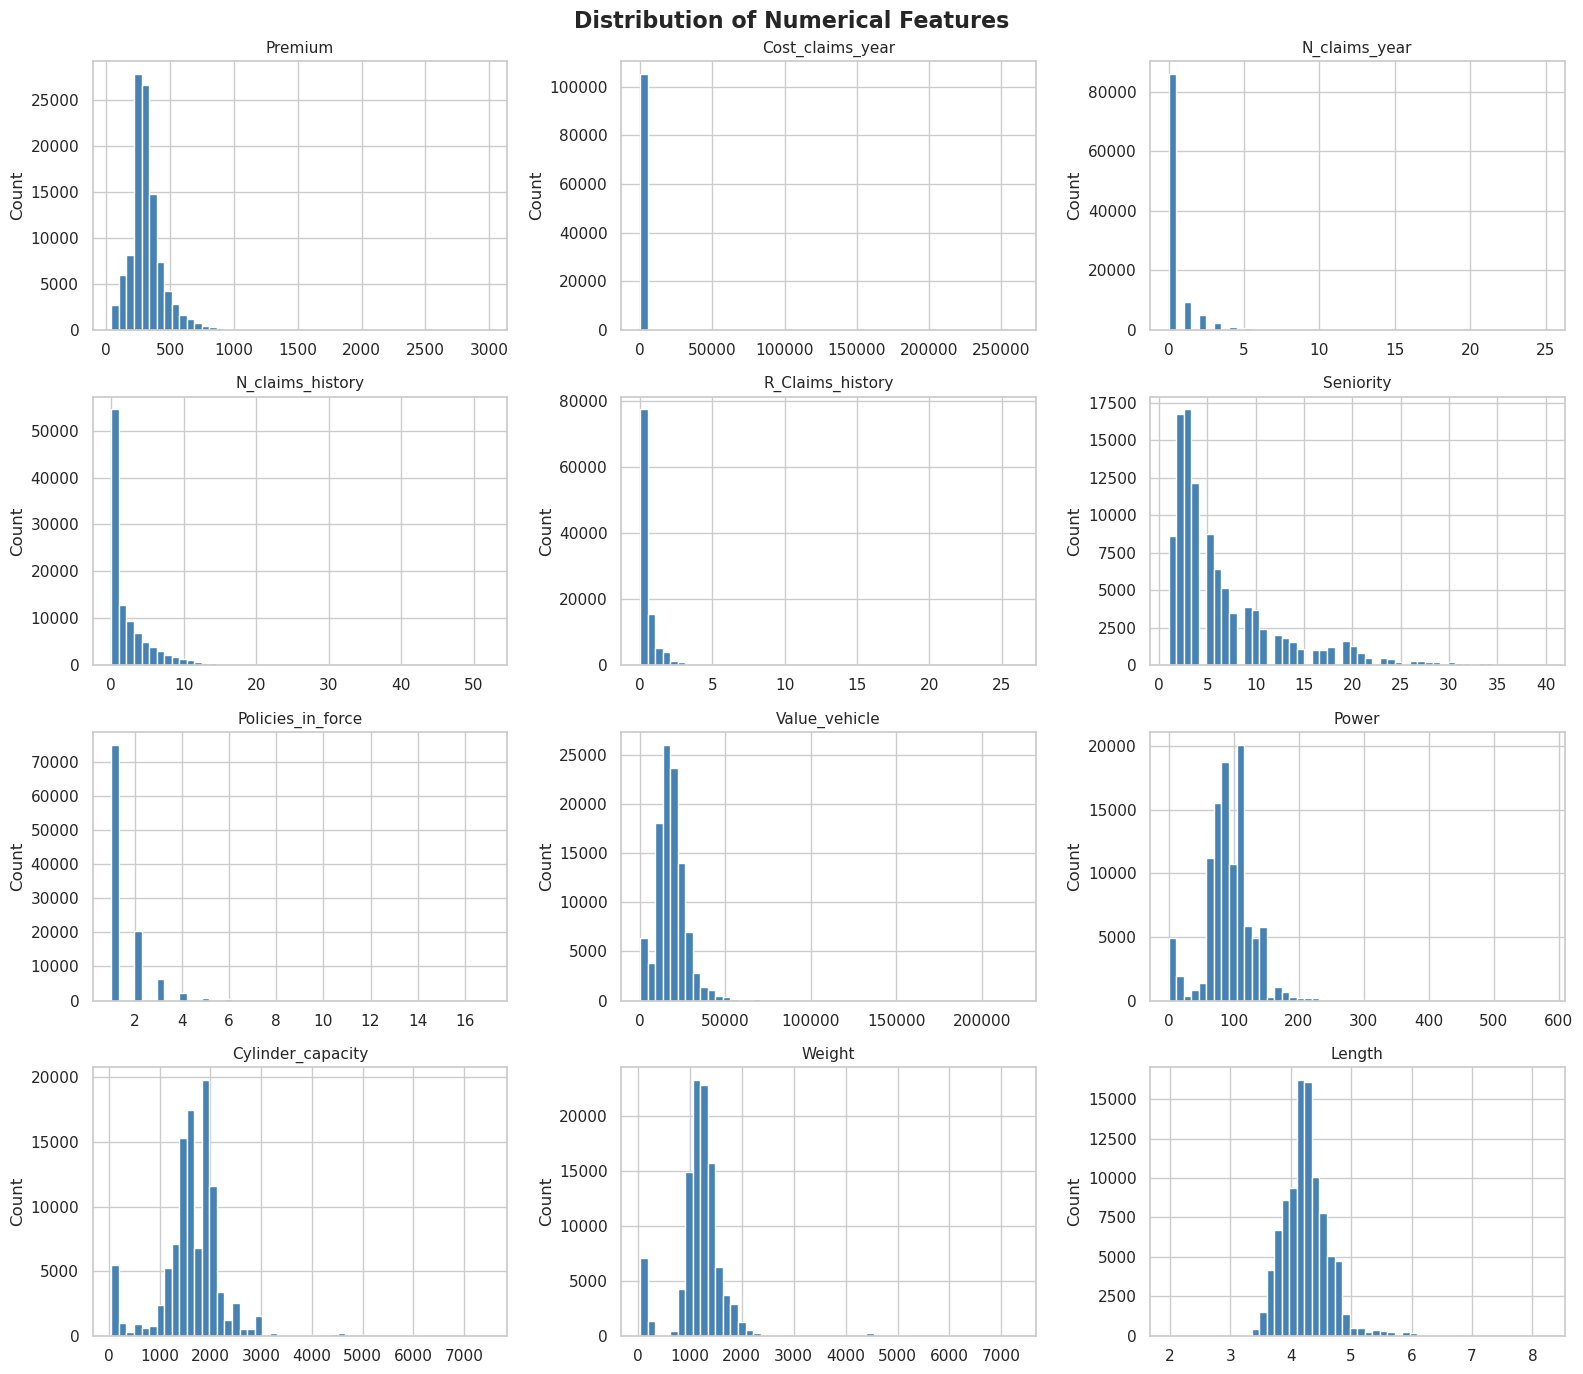

In [13]:
# Numerical feature distributions
num_cols = ['Premium', 'Cost_claims_year', 'N_claims_year', 'N_claims_history', 
            'R_Claims_history', 'Seniority', 'Policies_in_force', 'Value_vehicle',
            'Power', 'Cylinder_capacity', 'Weight', 'Length']

# Filter to columns that exist in the dataset
num_cols = [c for c in num_cols if c in df.columns]

fig, axes = plt.subplots(4, 3, figsize=(16, 14))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

for i, col in enumerate(num_cols):
    ax = axes[i // 3][i % 3]
    df[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(col, fontsize=11)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('num_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature Differences: Lapsed vs. Non-Lapsed

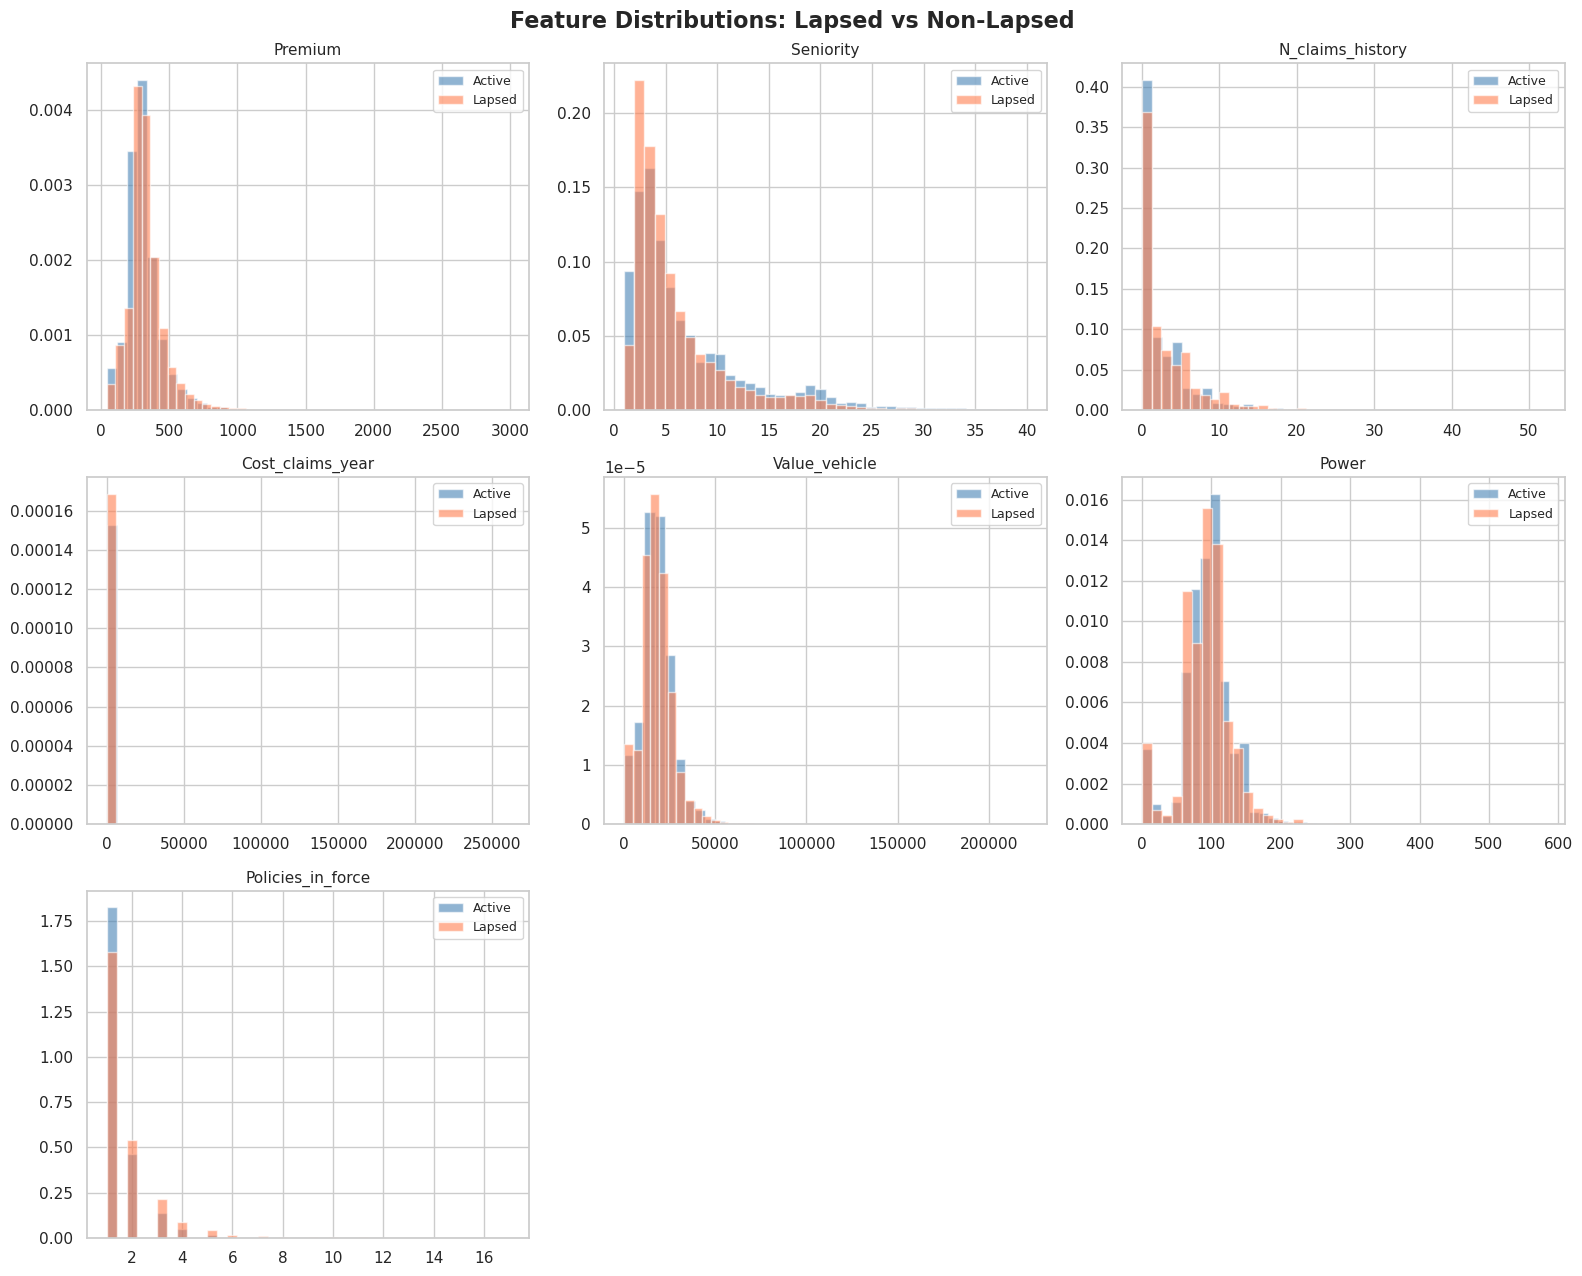

In [15]:
# Compare distributions by lapse status
compare_cols = ['Premium', 'Seniority', 'N_claims_history', 'Cost_claims_year',
                'Value_vehicle', 'Power', 'Policies_in_force']

fig, axes = plt.subplots(3, 3, figsize=(16, 13))
fig.suptitle('Feature Distributions: Lapsed vs Non-Lapsed', fontsize=16, fontweight='bold')

for i, col in enumerate(compare_cols):
    ax = axes[i // 3][i % 3]
    df[df['Lapsed']==0][col].hist(bins=40, ax=ax, alpha=0.6, color='steelblue', 
                                    label='Active', density=True)
    df[df['Lapsed']==1][col].hist(bins=40, ax=ax, alpha=0.6, color='coral', 
                                    label='Lapsed', density=True)
    ax.set_title(col, fontsize=11)
    ax.legend(fontsize=9)

# Hide unused subplots
for j in range(len(compare_cols), 9):
    axes[j // 3][j % 3].set_visible(False)

plt.tight_layout()
plt.savefig('lapse_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

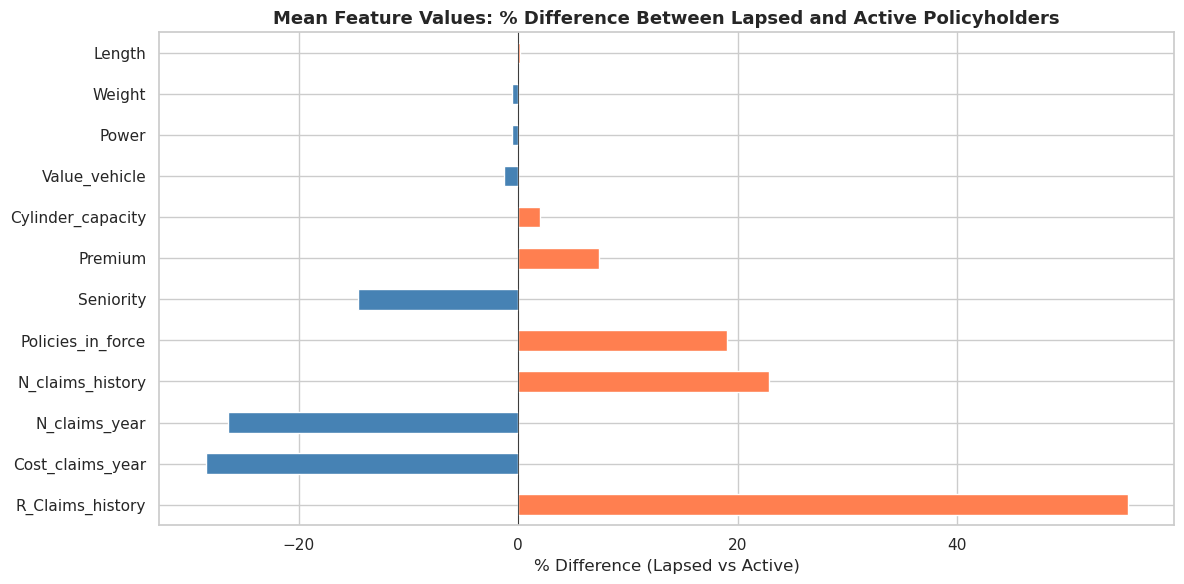

In [16]:
# Feature importance preview: mean differences by lapse status
compare_cols = ['Premium', 'Seniority', 'N_claims_history', 'R_Claims_history',
                'Cost_claims_year', 'N_claims_year', 'Value_vehicle', 'Power', 
                'Policies_in_force', 'Cylinder_capacity', 'Weight', 'Length']

means = df.groupby('Lapsed')[compare_cols].mean()
pct_diff = ((means.loc[1] - means.loc[0]) / means.loc[0] * 100).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['coral' if x > 0 else 'steelblue' for x in pct_diff.values]
pct_diff.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('% Difference (Lapsed vs Active)')
ax.set_title('Mean Feature Values: % Difference Between Lapsed and Active Policyholders', 
             fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('feature_importance_preview.png', dpi=150, bbox_inches='tight')
plt.show()

### Key Insight: Strongest Predictive Signals

**Claims history is the dominant predictor of lapse.** R_Claims_history (+50%) and N_claims_history (+22%) show that policyholders with more claims in their past are far more likely to lapse. However, current-year claims (Cost_claims_year, N_claims_year) are actually *lower* for lapsers, suggesting the lapse decision is driven by premium increases from prior-year claims rather than current-year activity.

**Customer tenure matters.** Lower seniority among lapsers indicates newer customers are higher flight risks.

**Vehicle characteristics don't predict lapse.** Weight, Power, Length, and Cylinder_capacity show negligible differences, suggesting lapse is a behavioral/pricing phenomenon, not a vehicle-driven one.

## 5. Feature Correlations

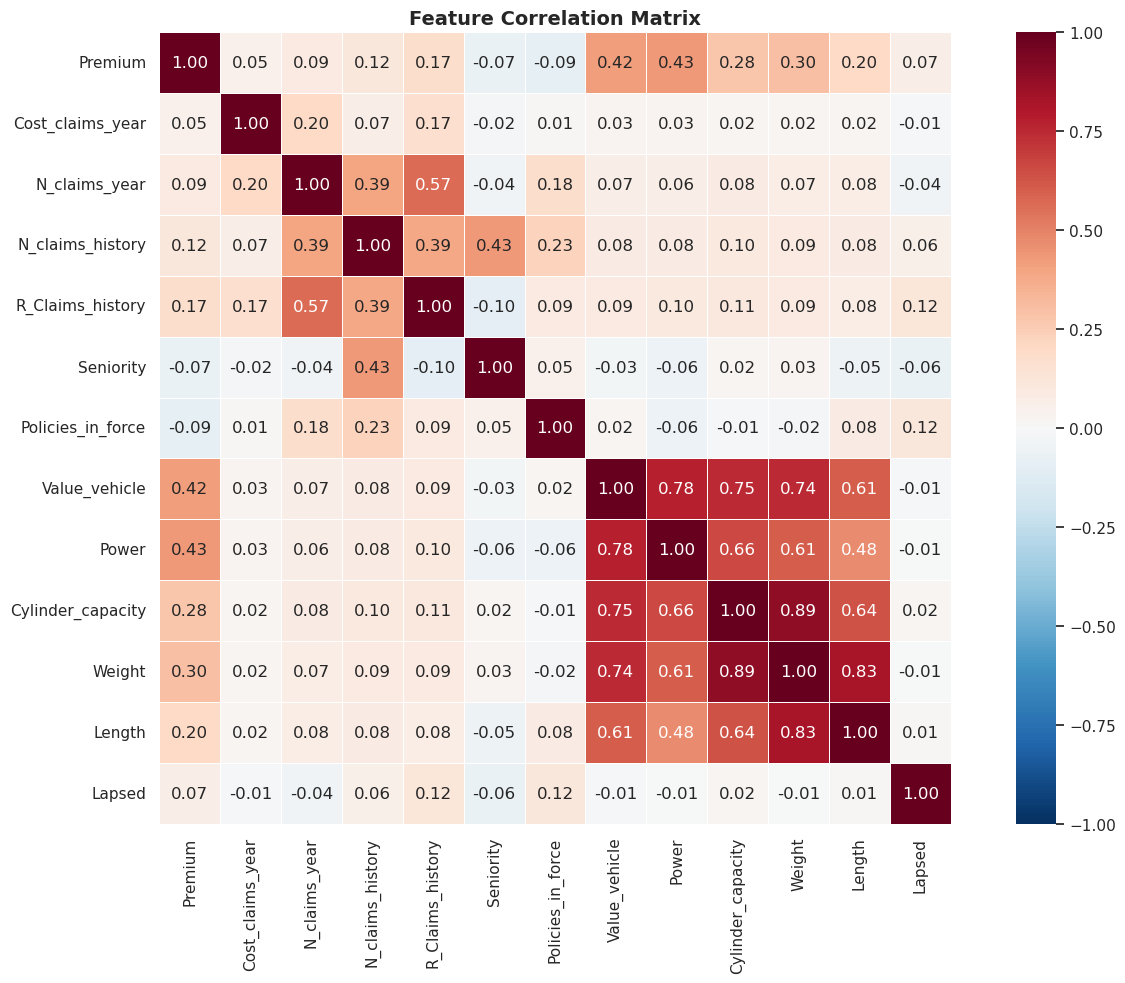

In [17]:
# Correlation heatmap
corr_cols = ['Premium', 'Cost_claims_year', 'N_claims_year', 'N_claims_history',
             'R_Claims_history', 'Seniority', 'Policies_in_force', 'Value_vehicle',
             'Power', 'Cylinder_capacity', 'Weight', 'Length', 'Lapsed']

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### Correlation Insights

Individual feature correlations with lapse are modest (max 0.12), which is typical for behavioral prediction problems. The strongest linear signals are N_claims_history (0.12), Policies_in_force (0.12), and Premium (0.07). Vehicle characteristics show near-zero correlation.

**Important:** Low linear correlation does not mean low predictive power. Non-linear relationships and feature interactions (which XGBoost captures well) may reveal stronger signals during modeling.

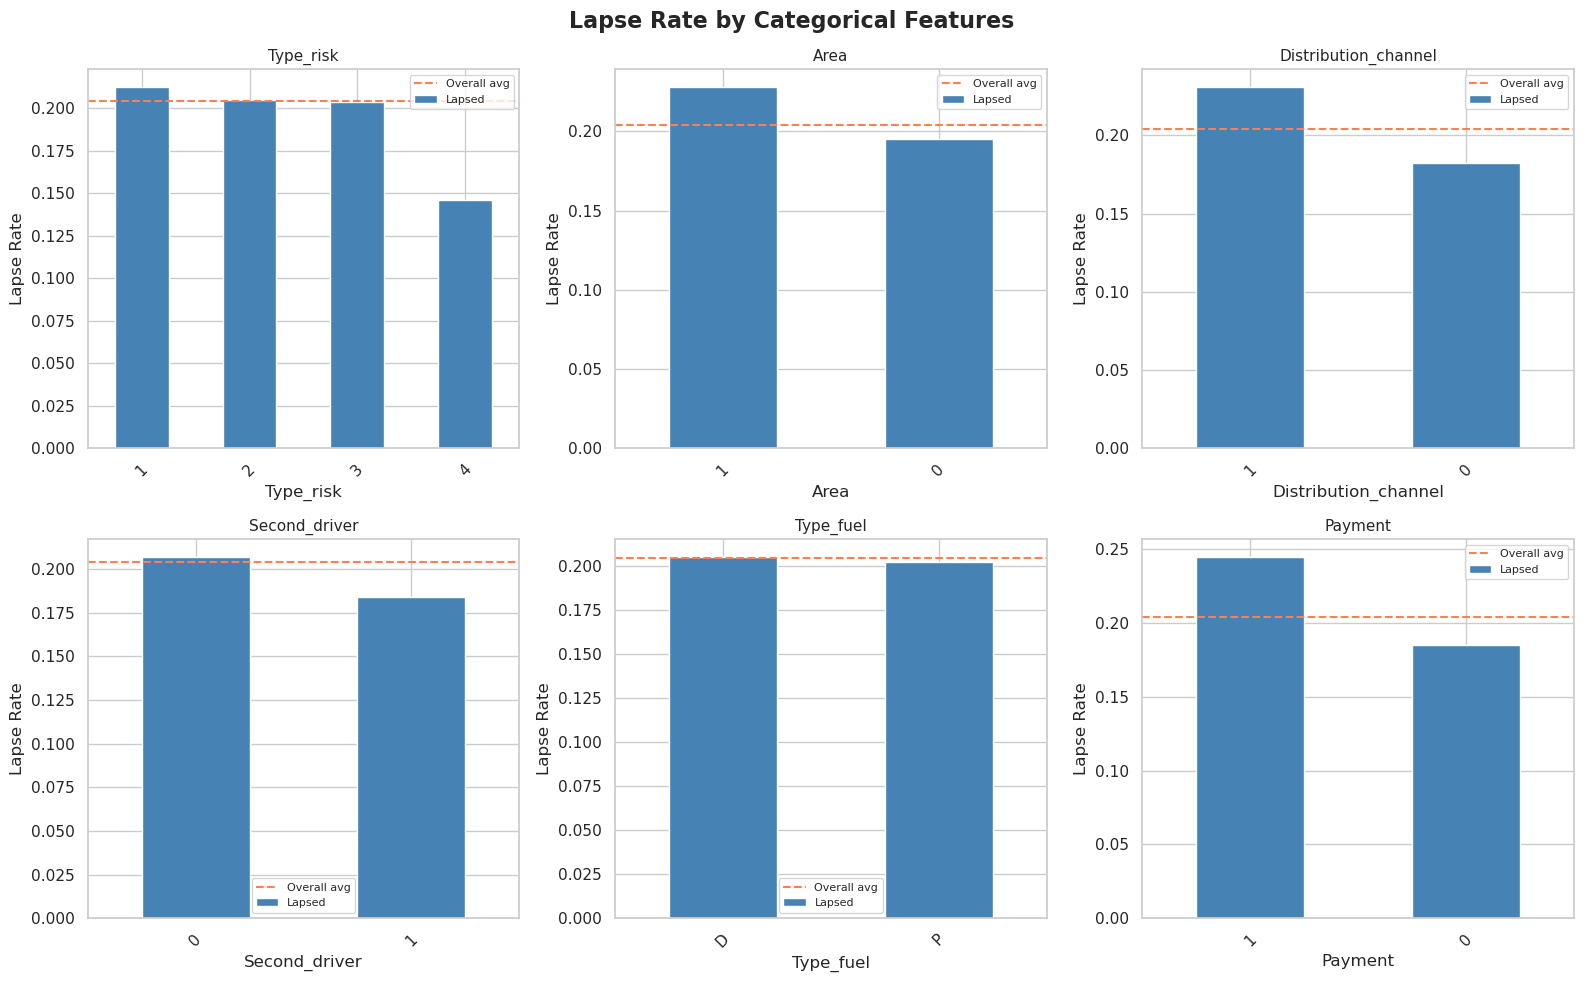

In [18]:
# Categorical feature analysis
cat_cols = ['Type_risk', 'Area', 'Distribution_channel', 'Second_driver', 
            'Type_fuel', 'Payment']
cat_cols = [c for c in cat_cols if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Lapse Rate by Categorical Features', fontsize=16, fontweight='bold')

for i, col in enumerate(cat_cols):
    ax = axes[i // 3][i % 3]
    lapse_rates = df.groupby(col)['Lapsed'].mean().sort_values(ascending=False)
    lapse_rates.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(col, fontsize=11)
    ax.set_ylabel('Lapse Rate')
    ax.axhline(y=df['Lapsed'].mean(), color='coral', linestyle='--', label='Overall avg')
    ax.legend(fontsize=8)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('categorical_lapse_rates.png', dpi=150, bbox_inches='tight')
plt.show()

### Categorical Feature Insights

- **Type_risk:** Category 4 shows a meaningfully lower lapse rate (~15%) compared to categories 1-3 (~20%). Risk classification matters for retention.
- **Payment:** The strongest categorical signal. Category 0 shows ~24% lapse rate vs ~15% for category 1. If these represent payment frequencies (e.g., monthly vs. annual), annual payers are more committed — which aligns with insurance industry patterns.
- **Area, Distribution_channel:** Modest differences between categories, worth including in the model.
- **Second_driver, Type_fuel:** Minimal differences from the overall average — weak predictive signals.

*Note: Feature labels are numeric codes. Original category definitions are not provided in the dataset documentation. Interpretations above are inferred from patterns.*

## 6. EDA Summary and Key Findings

### Dataset Structure
- 105,555 policy-year records representing 53,502 unique customers over a 3-year window (2015–2018)
- Average of 2.0 policy-years per customer
- 30 features covering policyholder demographics, policy details, claims history, and vehicle characteristics

### Target Variable
- Record-level lapse rate: 20.4% (moderately imbalanced, manageable for modeling)
- Customer-level lapse rate: 38.4% over the observation period
- Lapse column encodes count of lapses (0–7), converted to binary for modeling

### Strongest Predictive Signals
1. **Claims history (R_Claims_history, N_claims_history):** Dominant predictors. Higher historical claims strongly associate with lapse, likely driven by premium increases.
2. **Current-year claims (Cost_claims_year, N_claims_year):** Inversely related — lapsers have *lower* current-year claims, suggesting lapse is a lagged response to past claims.
3. **Policies_in_force:** More active policies correlate with higher lapse — possible indicator of price-shopping behavior.
4. **Seniority:** Newer customers lapse more — tenure builds retention.
5. **Premium:** Higher premiums weakly associate with lapse.
6. **Payment method:** Strongest categorical signal — payment type significantly affects lapse rate.
7. **Vehicle characteristics:** Negligible predictive power.

### Implications for Feature Engineering
- Engineer temporal features: premium change year-over-year, claims trend, time since last claim
- Create binary indicators from zero-inflated claims features
- Split data by customer ID (not randomly) to prevent data leakage
- Consider interaction features: claims history × premium level
- Log-transform right-skewed features (Premium, Value_vehicle)

### Implications for Business Action
- Claims-driven lapse is the primary retention challenge — proactive outreach after claim events
- Payment method optimization could improve retention with minimal cost
- New customer onboarding and early-tenure engagement are high-value retention strategies